<a href="https://colab.research.google.com/github/koopie3/Group-6-Fine-Tuning-Llama-2-7b-chat/blob/main/notebooks/fine-tuning_llama2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fine-Tuning the Llama-2-7B-Chat Model for Science-Based Multiple Choice Questions
This notebook details the process of optimizing the Llama-2-7B-Chat model specifically for answering science-based multiple choice questions. The methodologies employed are derived from the work presented here: https://github.com/edumunozsala/llama-2-7B-4bit-python-coder/blob/main/Llama-2-finetune-qlora-python-coder.ipynb

In [1]:
!pip install transformers datasets langchain accelerate torch peft bitsandbytes  trl
!pip install optimum
!pip install auto-gptq

In [2]:

import tensorflow as tf

# Check GPU availability
print("GPU Available:", tf.test.is_gpu_available())

# Check TPU availability
tpu_available = False
devices = tf.config.list_logical_devices()
for device in devices:
    if device.device_type == 'TPU':
        tpu_available = True
        break

print("TPU Available:", tpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True
TPU Available: False


In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import pandas as pd
from string import Template
from pathlib import Path
import matplotlib.pyplot as plt

import os

import warnings
warnings.simplefilter("ignore")

from tqdm.notebook import tqdm

# for training
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
# for traing set
from datasets import load_dataset
from langchain.prompts import PromptTemplate
import matplotlib.pyplot as plt
import bitsandbytes as bnb
import numpy as np

from IPython.display import Markdown, display

In [4]:
device_map = {"": 0} # Load model on GPU 0
model_name = "NousResearch/Llama-2-7b-chat-hf"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtyp=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map = device_map
)
# this should be set as False for finetuning
model.config.use_cache = False

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# change filepath
filepath = '/content/drive/MyDrive/Dataset /df_train_100.csv'
train_dataset = load_dataset("csv", data_files=filepath)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
# prepare template context
template = """Answer the following multiple choice question by giving the most appropriate response. Answer should be one among [A, B, C, D, E]

Question: {context}\n
{prompt}\n
A) {a}\n
B) {b}\n
C) {c}\n
D) {d}\n
E) {e}\n

### Answer: {answer}"""

prompt = PromptTemplate(template=template, input_variables=['prompt', 'context', 'a', 'b', 'c', 'd', 'e', 'answer'])

In [ ]:
# prepare template without context
template = """Answer the following multiple choice question by giving the most appropriate response. Answer should be one among [A, B, C, D, E]

Question: {prompt}\n
A) {a}\n
B) {b}\n
C) {c}\n
D) {d}\n
E) {e}\n

### Answer: {answer}"""

prompt = PromptTemplate(template=template, input_variables=['prompt', 'a', 'b', 'c', 'd', 'e', 'answer'])

In [ ]:
def format_text(example):
    """ fill inputs in promt for a sample  """
    text = prompt.format(prompt=example['prompt'],
                         context = example['context'],
                         a=example['A'],
                         b=example['B'],
                         c=example['C'],
                         d=example['D'],
                         e=example['E'],
                         answer=example['answer'])
    return {"text": text}

In [ ]:
train_dataset = train_dataset.map(format_text)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
print(train_dataset['train'][0]['text'])

Answer the following multiple choice question by giving the most appropriate response. Answer should be one among [A, B, C, D, E]

Question: A large fraction of the chemical elements that occur naturally on the earth's surface are essential to the structure and metabolism of living things. The following table identifies the 94 chemical elements that occur naturally on the earth's surface, their atomic numbers, their biological rank as defined above, and their general beneficial and harmful roles in living things. * Apart from the known essential elements, most elements have only received direct biological study in connection with their significance to human health; this has incidentally included study of some laboratory animals such as chickens and rats, and plants of agricultural importance. Four of these elements (hydrogen, carbon, nitrogen, and oxygen) are essential to every living thing and collectively make up 99% of the mass of protoplasm. The remaining elements found in living t

In [ ]:
# check model structure
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear4bit(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )


In [ ]:
# Fine-tuned model name
new_model = "llama_finetuned"

################################################################################
# QLoRA parameters
################################################################################
# LoRA attention dimension
lora_r = 64
# Alpha parameter for LoRA scaling
lora_alpha = 16
# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# TrainingArguments parameters
################################################################################
# Output directory where the model predictions and checkpoints will be stored
output_dir = new_model
# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = True
bf16 = False
# Batch size per GPU for training
per_device_train_batch_size = 4
# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1
# Enable gradient checkpointing
gradient_checkpointing = True
# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3
# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4
# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001
# Optimizer to use
optim = "paged_adamw_32bit"
# Learning rate schedule
lr_scheduler_type = "cosine" #"constant"
# Number of training steps (overrides num_train_epochs)
max_steps = -1
# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03
# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = False
# Save checkpoint every X updates steps
save_steps = 0
# Log every X updates steps
logging_steps = 25
# Disable tqdm
disable_tqdm= False
################################################################################
# SFTTrainer parameters
################################################################################
# Maximum sequence length to use
max_seq_length = 2048 #None


In [ ]:
# Additional model configuration
model.config.pretraining_tp = 1
tokenizer.padding_side = "right"

In [ ]:
# LoRA config based on QLoRA paper
peft_config = LoraConfig(
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        r=lora_r,
        bias="none",
        task_type="CAUSAL_LM",
)

In [ ]:
# Define the training arguments
args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    per_device_train_batch_size=per_device_train_batch_size, # 6 if use_flash_attention else 4,
    gradient_accumulation_steps=gradient_accumulation_steps,
    gradient_checkpointing=gradient_checkpointing,
    optim=optim,
    #save_steps=save_steps,
    logging_steps=logging_steps,
    save_strategy="epoch",
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    warmup_ratio=warmup_ratio,
    #max_steps=max_steps,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    disable_tqdm=disable_tqdm,
    report_to="tensorboard",
    seed=42
)

In [ ]:
supervised_finetuning_trainer = SFTTrainer(
    model,
    train_dataset=train_dataset['train'],
    args=args,
    tokenizer=tokenizer,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    data_collator=DataCollatorForCompletionOnlyLM(tokenizer=tokenizer,
                                                  response_template="Answer:"))

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
supervised_finetuning_trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
25,1.791600
50,1.052600
75,0.652400
100,0.325800
125,0.169200


TrainOutput(global_step=125, training_loss=0.7983059310913085, metrics={'train_runtime': 848.3346, 'train_samples_per_second': 0.589, 'train_steps_per_second': 0.147, 'total_flos': 9231379558563840.0, 'train_loss': 0.7983059310913085, 'epoch': 5.0})

In [ ]:
# save model in local
# change output_dir
output_dir = '/content/drive/MyDrive/Finetuned_models/finetuned_5epochs_context/'
supervised_finetuning_trainer.save_model(output_dir)

In [ ]:
# only save adapter in local
output_dir = "outputs"
model_to_save = supervised_finetuning_trainer.model.module if hasattr(supervised_finetuning_trainer.model, 'module') else supervised_finetuning_trainer.model
model_to_save.save_pretrained(output_dir)

# Loading Fine-Tuned Model


In [4]:
device_map = {"": 0} # load model on gpu 0

# specify filepath
model_name = "/content/drive/MyDrive/Finetuned_models/finetuned_5epochs_context"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtyp=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    quantization_config=bnb_config,
    device_map = device_map
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(
            in_features=4096, out_features=4096, bias=False
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=4096, out_features=64, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=64, out_features=4096, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (k_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear4bit(
            in_features=4096, out_features=4096, bias=False
            (lora_dropout): ModuleDict(
              (default): 

# Evaluation
The following section contains code adapted from Kaggle https://www.kaggle.com/code/cmsm12/locally-fine-tuning-llama-2-using-qlora. This code is designed to generate predictions from llama2-7b-chat after it has been fine-tuned. It does this by defining a custom Perplexity function, that provides a way to quantify how well the probability distribution predicted by the model aligns with the true data. This function is used for every sample in the test set for each possible answer choice (A to E), then it gives the top 3 predictions in format suited for the Kaggle LLM competition format https://www.kaggle.com/competitions/kaggle-llm-science-exam.

In [6]:
# prepare template without context
template = """Answer the following multiple choice question by giving the most appropriate response. Answer should be one among [A, B, C, D, E]

Question: {prompt}\n
A) {a}\n
B) {b}\n
C) {c}\n
D) {d}\n
E) {e}\n

### Answer: {answer}"""

prompt = PromptTemplate(template=template, input_variables=['prompt', 'a', 'b', 'c', 'd', 'e', 'answer'])

In [7]:
# We don't have answers for test
def format_text_test(example):
    text = prompt.format(prompt=example['prompt'],
                         a=example['A'],
                         b=example['B'],
                         c=example['C'],
                         d=example['D'],
                         e=example['E'],
                         answer='')
    return {"text": text}


test_dataset = load_dataset("csv", data_files="/content/drive/MyDrive/Dataset /df_test.csv")
test_dataset = test_dataset.map(format_text_test)

In [8]:
# sample question for evaluation
print(test_dataset['train'][0]['text'])

Answer the following multiple choice question by giving the most appropriate response. Answer should be one among [A, B, C, D, E]

Question: What are control systems engineering activities focused on?

A) Developing mathematical models of control systems

B) Implementing control systems in physical systems

C) Using control system design tools to develop controllers

D) Understanding physical systems in terms of inputs, outputs, and various components with different behaviors

E) All of the above


### Answer: 


In [9]:
# Import necessary library
from torch import nn

# Define a Perplexity class which inherits from nn.Module
class Perplexity(nn.Module):
    # Initialization method for the class
    def __init__(self, reduce: bool = True):
        # Call the initialization method of the parent class
        super().__init__()

        # Define the cross entropy loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Boolean flag to determine if the perplexity should be averaged (reduced) over the batch
        self.reduce = reduce

    # Define the forward pass for computing perplexity
    def forward(self, logits, labels):
        # Shift logits to exclude the last token since we don't have a label for it
        shift_logits = logits[..., :-1, :].contiguous()

        # Shift labels to exclude the first token because it doesn't have a corresponding logit
        shift_labels = labels[..., 1:].contiguous()

        # List to store the perplexity of each sample in the batch
        perplexity = []
        for i in range(labels.shape[0]):
            # Compute the cross entropy loss for each sample and append to the list
            perplexity.append(self.loss_fn(shift_logits[i], shift_labels[i]))

        # Convert the list of perplexities into a tensor
        perplexity = torch.stack(perplexity, dim=0)

        # If the reduce flag is set to True, average the perplexities over the batch
        if self.reduce:
            perplexity = torch.mean(perplexity)

        # Return the final perplexity value
        return perplexity

# Instantiate an object of the Perplexity class
perp = Perplexity()


In [10]:
# List to store the final predictions
preds = []
top_perplexities = []

# Iterate through each sample in the test_dataset
for idx in tqdm(range(len(test_dataset["train"])), total=len(test_dataset["train"])):

    # Ensure that no gradients are computed during this process,
    # which saves memory and speeds up computation
    with torch.no_grad():
        # Define the answer options
        cols = ["A", "B", "C", "D", "E"]

        # Lists to store perplexities and sample prompts for each answer option
        perps = []
        samples = []

        # Create sample prompts for each answer option and add them to the samples list
        for col in cols:
            prompt = test_dataset['train'][idx]['text']
            samples.append(prompt + col)

        # Tokenize the sample prompts, convert them to tensors, and move them to the GPU
        inputs = tokenizer(samples, return_tensors="pt", add_special_tokens=False, padding=True, truncation=True).to("cuda")

        # Pass the tokenized inputs through the model to get the output logits
        output = model(input_ids=inputs["input_ids"], attention_mask=inputs["attention_mask"])
        output = output.logits

        # The labels are essentially the input tokens in this context
        labels = inputs["input_ids"]
        # Mask labels that correspond to padding tokens
        labels.masked_fill_(~inputs["attention_mask"].bool(), -100)

        # Calculate the perplexity for each answer option and append it to the perps list
        for j in range(len(cols)):
            p = perp(output[j].unsqueeze(0), labels[j].unsqueeze(0))
            perps.append(p.detach().cpu())

        # Clear unnecessary variables from memory to free up GPU space
        del inputs
        del labels
        del output
        del p

    # Convert perps list to a numpy array
    perps = np.array(perps)
    #print('before', perps)
    sorted_indices = np.argsort(perps)
    top_3_perplexities = perps[sorted_indices][:3]
    #print('after', perps)
    top_perplexities.append(top_3_perplexities)

    # Sort the answer options based on their perplexity and store the sorted list as predictions
    predictions = [np.array(cols)[np.argsort(perps)]]
    preds.append(predictions)


  0%|          | 0/50 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [11]:
def format_prediction(row, k=3):
    best_k_preds = row[0][:k]
    return ' '.join(best_k_preds)

test_df = pd.DataFrame(preds)
format_prediction(test_df.iloc[0, :])
test_df['prediction'] = test_df.apply(lambda x: format_prediction(x), axis=1)
test_df['id'] = test_df.index
test_df['perplexities'] = top_perplexities

submission = test_df[['id', 'prediction', 'perplexities']]

In [12]:
file_path = '/content/drive/MyDrive/Dataset /df_test.csv'
#file_path = '/content/drive/MyDrive/Dataset /df_train_100.csv'
df_test_org = pd.read_csv(file_path)

In [13]:
submission["true_answer"] = df_test_org['answer']
# Extract the first prediction and create a new column 'pred'
submission['most_likely'] = submission['prediction'].str.split().str[0]
submission.head(5)

,id,prediction,perplexities,true_answer,most_likely
0,0,E C D,"[2.3917775, 2.4244318, 2.4251513]",E,E
1,1,B E C,"[1.9639031, 2.0494108, 2.0727208]",B,B
2,2,D E C,"[1.925176, 1.9739354, 2.0155244]",D,D
3,3,B E C,"[1.5279729, 1.5507526, 1.561956]",B,B
4,4,B C E,"[2.4416516, 2.4468758, 2.4514077]",A,B


In [67]:
# Load results
#submission = pd.read_csv("/content/drive/MyDrive/Dataset /results_context_10.csv")

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(submission['true_answer'], submission['most_likely'])

0.5

In [17]:
submission.to_csv('/content/drive/MyDrive/Dataset /results_context.csv', index=False)

In [15]:
def average_precision_at_k(row, k=3):
    # Split the prediction string into a list of predictions.
    predictions = row['prediction'].split()

    # Extract the true answer.
    true_answer = row['true_answer']

    # If the number of predictions is greater than k, truncate the list.
    if len(predictions) > k:
        predictions = predictions[:k]

    # Initialize the score (used to store the sum of precisions for relevant items).
    score = 0.0

    # num_hits will store the count of correct predictions encountered so far.
    num_hits = 0

    # rel_count will store the count of relevant items (correct answers) encountered so far.
    rel_count = 0

    # Iterate through each prediction.
    for i, p in enumerate(predictions):

        # If the current prediction is correct and hasn't been accounted for before.
        if p == true_answer and p not in predictions[:i]:

            # Increase the count of relevant items.
            rel_count += 1

            # Increase the count of correct predictions.
            num_hits += 1

            # Calculate precision at this point and add to the score.
            score += num_hits / (i + 1.0)

    # If no relevant items found, return AP as 0.
    if rel_count == 0:
        return 0.0

    # Return the average precision for this set of predictions.
    return score

def map_at_k(df, k=3):
    # Apply the average_precision_at_k function to each row in the dataframe
    # and then compute the mean of the results to get MAP@k.
    return df.apply(average_precision_at_k, axis=1, k=k).mean()


In [16]:
# Compute MAP@3
print(map_at_k(submission))

0.62


# Visualizations


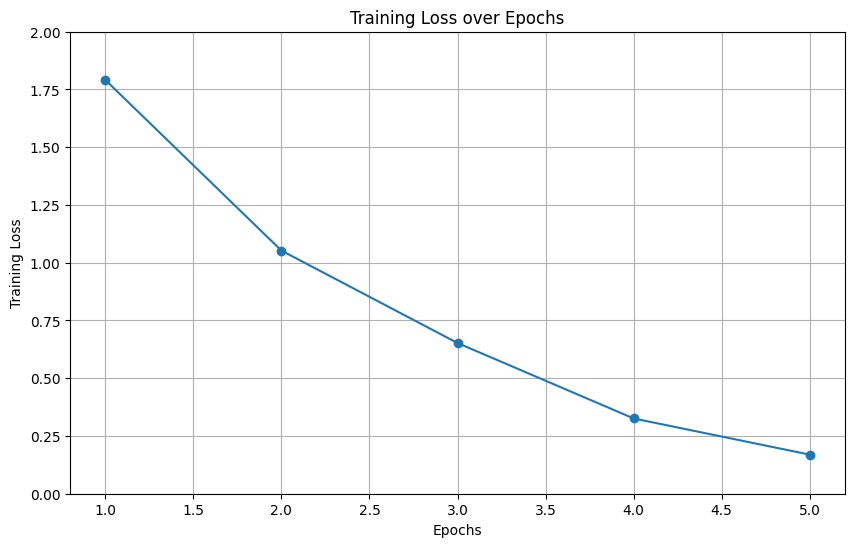

In [38]:
# training context 5 epochs
data = {
    'Epoch': [1, 2, 3, 4, 5],
    'Training Loss': [1.791600, 1.052600, 0.652400, 0.325800, 0.169200]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Training Loss'], marker='o', linestyle='-')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.ylim(0, 2)  # Setting the y-axis limits
plt.grid(True)
plt.show()

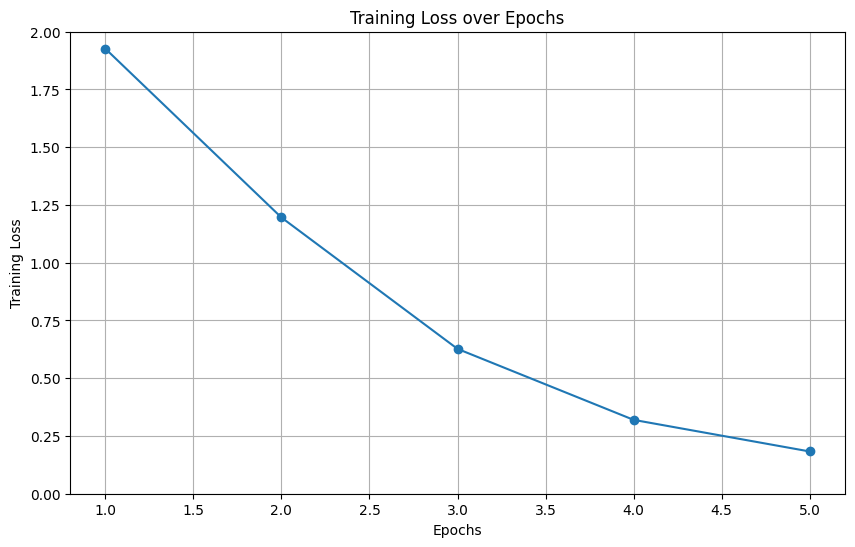

In [39]:
# training no context 5 epochs
data = {
    'Epoch': [1, 2, 3, 4, 5],
    'Training Loss': [1.927000, 1.195900, 0.627000, 0.319700, 0.182800]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Training Loss'], marker='o', linestyle='-')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.ylim(0, 2)  # Setting the y-axis limits
plt.grid(True)
plt.show()

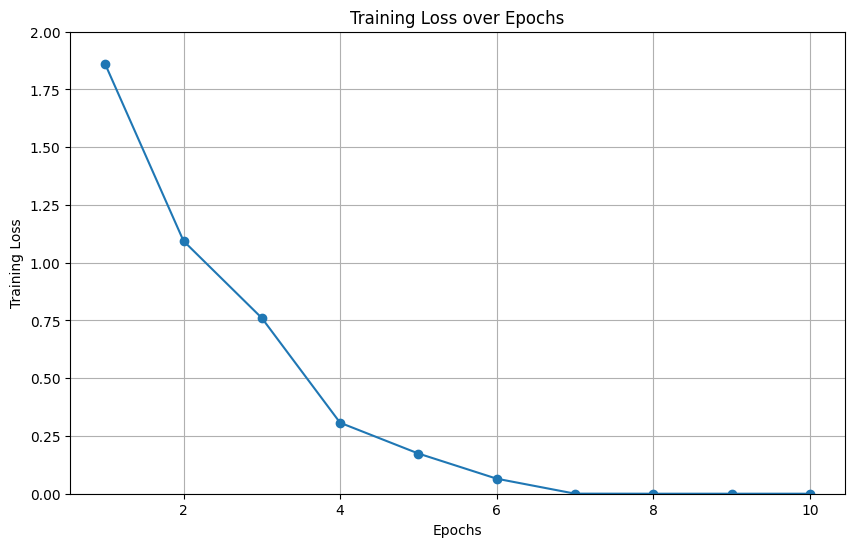

In [37]:
# no context 10 epochs
data = {
    'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'Training Loss': [1.859100, 1.094100, 0.760600, 0.307300, 0.174000, 0.065100, 0.000300, 0.000000, 0.000000, 0.000000]
}

# Create DataFrame
df = pd.DataFrame(data)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df['Epoch'], df['Training Loss'], marker='o', linestyle='-')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.ylim(0, 2)  # Setting the y-axis limits
plt.grid(True)
plt.show()